<a href="https://colab.research.google.com/github/vitorpohlenz/PPGMTM_UFSC/blob/main/Final_Project/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Autors:
Tiago César Busata

Vitor Pohlenz 

# Libraries

In [252]:
# Common Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss

# Set seed
seed = 9
np.random.seed(seed)

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import (plot_confusion_matrix, fbeta_score, accuracy_score, confusion_matrix)
from sklearn.pipeline import (make_pipeline, Pipeline)
from sklearn.preprocessing import (FunctionTransformer, StandardScaler, RobustScaler)
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

## Library for imbalance data.
from imblearn.under_sampling import NearMiss as UnderNearMiss

## Models
from sklearn.linear_model import (LogisticRegression, SGDClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

Dark theme better visualization.

In [162]:
# Plot's Layout
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize = [12,8])

import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Functions

Test for association between categorical variables.

Based in Pearson's $\chi^2$ test, also kown as [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V).

Reference for this function can be find [here](https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792). Using Bias corretion.

In [163]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Log transformations

In [164]:
def LogColumns(dataframe, logFun, columns):
  df = dataframe.copy()
  df[columns] = df[columns].apply(lambda xcol: logFun(xcol+1))
  return df.copy()

Scaler only to numerical variables.

In [165]:
def NumericalScaler(dataframe, scaler, NumericalColumns):
  df = dataframe.copy()
  scaler.fit(df[NumericalColumns])
  df[NumericalColumns] = scaler.transform(df[NumericalColumns])
  return df.copy()

# Data import from Google Drive

In [167]:
from google.colab import drive 
drive.mount('/content/drive')
raw_data = pd.read_csv('drive/My Drive/Colab Notebooks/Curso de verão/Final_Project/census.csv')
# data = pd.read_csv('census.csv')
raw_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


# Overview of data

Ubalanced data set.

In [168]:
raw_data['income'].value_counts()/raw_data.shape[0]

<=50K    0.752156
>50K     0.247844
Name: income, dtype: float64

Data info

In [169]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


Data do not have NaN values.

In [170]:
raw_data.isna().sum().sum()

0

Columns: `'education_level'` and `'education-num'` have the same information. 

One numeric and other categorical.

In [171]:
raw_data[['education_level','education-num']].groupby('education_level'). agg({"education-num": ["unique","nunique"]})

education-num        
                       unique nunique
education_level                      
 10th                   [6.0]       1
 11th                   [7.0]       1
 12th                   [8.0]       1
 1st-4th                [2.0]       1
 5th-6th                [3.0]       1
 7th-8th                [4.0]       1
 9th                    [5.0]       1
 Assoc-acdm            [12.0]       1
 Assoc-voc             [11.0]       1
 Bachelors             [13.0]       1
 Doctorate             [16.0]       1
 HS-grad                [9.0]       1
 Masters               [14.0]       1
 Preschool              [1.0]       1
 Prof-school           [15.0]       1
 Some-college          [10.0]       1

## Dealing with categorical variables.
`'education_level'` can be droped, because `'education-num'` is its equivalent but numeric.

Using [get.dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) from pandas.

In [172]:
categorical_columns=['workclass', 'marital-status', 'occupation', 
                     'relationship', 'race', 'sex', 'native-country'] # 'income' is the target

numerical_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

data = pd.get_dummies(data = raw_data.drop(labels = 'education_level', axis = 1), 
                      columns=categorical_columns, drop_first=True)

data['income'] = data.income.map({'<=50K':0, '>50K':1})

data.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,...,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13.0,2174.0,0.0,40.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,13.0,0.0,0.0,13.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,9.0,0.0,0.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,7.0,0.0,0.0,40.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,13.0,0.0,0.0,40.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Test Train Split

Features and Target

In [173]:
nm_features = data.drop(labels='income', axis = 1).columns.tolist()
nm_target = 'income'               

Using [NearMiss()](https://imbalanced-learn.org/stable/generated/imblearn.under_sampling.NearMiss.html) to balance data.

In [174]:
NearMiss =  UnderNearMiss(n_jobs=-1, random_state = seed)
NearMiss.fit_sample(data[nm_features], data[nm_target])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(array([[4.9000e+01, 9.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.6000e+01, 9.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.8000e+01, 9.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.3000e+01, 1.4000e+01, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.0000e+01, 1.5000e+01, 1.5024e+04, ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.5000e+01, 1.3000e+01, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]]), array([0, 0, 0, ..., 1, 1, 1]))

Getting only indices from `NearMiss()` to keep data as `pandas.DataFrame()`.

In [175]:
NearMiss.sample_indices_

array([   27,    60,   338, ..., 45198, 45204, 45221])

As we can see, the indices excluded are only from Majoryty class.

In [176]:
data[~data.index.isin(NearMiss.sample_indices_)].income.unique()

array([0])

And now we hava balanced classes.

> Remember, the indices that are **not** in `NearMiss.sample_indices` can also be used in test! We can bootstrap they to have more than one test set, following the ***idea*** of Monte Carlo.

In [177]:
train, test = train_test_split(data.loc[NearMiss.sample_indices_], 
                               test_size=0.2, 
                               random_state = seed, 
                               shuffle=True, 
                               stratify=data.loc[NearMiss.sample_indices_,'income'])

train[nm_target].value_counts()/len(train)

1    0.5
0    0.5
Name: income, dtype: float64

# Exploratory analysis

<font color = "yellow"> WARNING ! </font>

<font color = "yellowgreen"> I will use `train.index` to access `raw_data` it means that actually Im using only the train set in Exploratory Analysis.</font>

In [178]:
expo_data = raw_data.loc[NearMiss.sample_indices_,:].copy()

## Using Cramer's V in categorical variables and target.

The limits of Cramer's V are [0,1].

Closer to one greater the association.

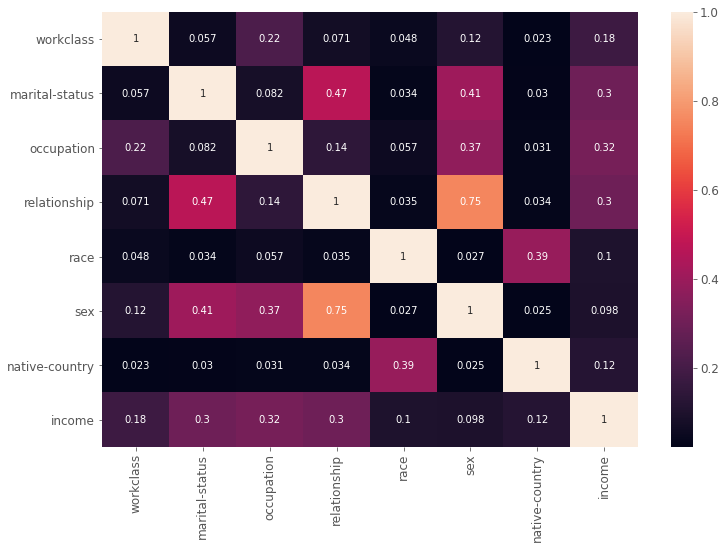

In [179]:
lcramer = []

for i in categorical_columns+[nm_target]:
  lrow = []
  for j in categorical_columns+[nm_target]:
    lrow.append(cramers_v(x = expo_data[i], y = expo_data[j]) ) 
  
  lcramer.append(lrow)

df_cramer = pd.DataFrame(data = lcramer, 
                         index = categorical_columns+[nm_target], 
                         columns= categorical_columns+[nm_target])

sns.heatmap(df_cramer, annot=True)
plt.show()

It seems that the bests associations with 'income' (target) are:
- `occupation`
- `marital-status`
- `relationship`

## Correlation between features.

It's interesting that features are not correlated each other.

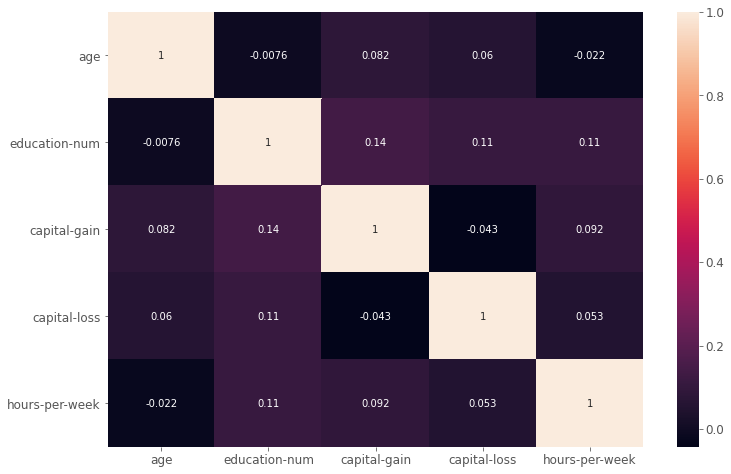

In [180]:
sns.heatmap(expo_data[numerical_columns].corr(), annot=True)
plt.show()

In [181]:
expo_data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,22416.000000,22416.000000,22416.000000,22416.000000,22416.000000
mean,41.699099,10.937188,1996.091497,97.045726,44.257004
std,10.420410,2.257084,10526.194227,430.610423,8.805288
min,19.000000,1.000000,0.000000,0.000000,1.000000
25%,34.000000,9.000000,0.000000,0.000000,40.000000
50%,41.000000,10.000000,0.000000,0.000000,40.000000
75%,49.000000,13.000000,0.000000,0.000000,50.000000
max,90.000000,16.000000,99999.000000,3683.000000,99.000000


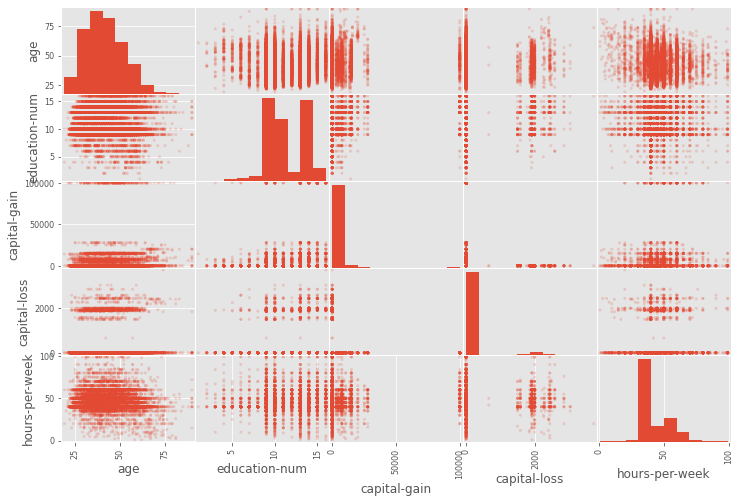

In [182]:
pd.plotting.scatter_matrix(expo_data, alpha=0.2)
plt.show()

It seems that features do not have correlations or dependency.

But `capital-gain` and `capital-loss` are quite asymmetric.

And their ranges are quite large.

Using a little 'trick' with log10(x+1) to see if the symmetry enhance. 

In [183]:
expo_data['log_capital-gain'] = np.log10(expo_data['capital-loss'] + 1)
expo_data['log_capital-loss'] = np.log10(expo_data['capital-gain'] + 1)

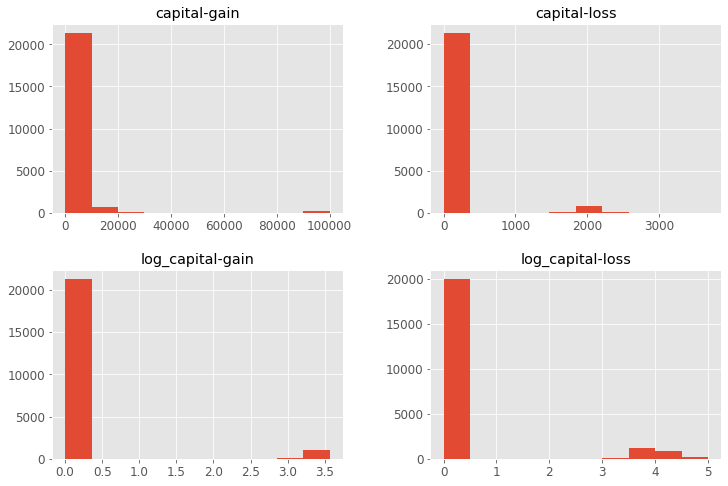

In [184]:
expo_data[['capital-gain','capital-loss','log_capital-gain','log_capital-loss']].hist()
plt.show()

In [185]:
(expo_data[['capital-gain','log_capital-gain','capital-loss','log_capital-loss']]
 .apply(lambda x: ss.kurtosis(x, bias=False)) )

capital-gain        73.982720
log_capital-gain    15.420847
capital-loss        16.990557
log_capital-loss     4.934303
dtype: float64

[kurtosis()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html) indicates how skewed is the distribution. 
In this case the higher kurtosis the greater asymmetry.

And how we can see above, the log10 in both cases reduce the kurtosis.

# Data Preprocessing

In [186]:
pipre = Pipeline([('log_transform', FunctionTransformer(LogColumns, validate = False,
                                                        kw_args = {'logFun' : np.log10, 
                                                                   'columns' : ['capital-gain', 'capital-loss']
                                                                   }
                                                        )
                   ),
                  ('scaler', FunctionTransformer(NumericalScaler, validate = False,
                                                 kw_args={'scaler':StandardScaler(),
                                                          'NumericalColumns':numerical_columns
                                                          }
                                                 )
                   )
                 ])

# Models

Using F1 score to give equal emphasis to precision and recall.

In [188]:
pipe = Pipeline(steps=[('pre_processing',pipre),
                        ('classifier', LogisticRegression(max_iter=1000, random_state = seed, n_jobs=-1))
                        ]
                )

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [LogisticRegression(max_iter=1000, random_state = seed, n_jobs=-1)],
                'classifier__C' : [0.5,0.75,1,1.25,1.5]
                },
                {'classifier': [SGDClassifier(random_state=seed,n_jobs=-1, n_iter_no_change=10, early_stopping=True)],
                 'classifier__penalty' : ['l1', 'l2', 'elasticnet']
                },
                {'classifier':[SVC(random_state=seed,cache_size = 400)],
                 'classifier__kernel' : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                 'classifier__C' : [0.5,0.75,1,1.25,1.5]
                },
                {'classifier':[KNeighborsClassifier(n_jobs=-1)],
                 'classifier__n_neighbors' : [5,10,15]
                },
                {'classifier':[AdaBoostClassifier(random_state=seed)],
                 'classifier__n_estimators' : [50,100,150,200,300,500]
                }
                ]

grid_model = GridSearchCV(estimator = pipe,param_grid = search_space, 
                          scoring = 'f1' ,
                          cv=5, verbose = True, n_jobs=-1)

In [189]:
model = grid_model.fit(train[nm_features], train[nm_target])

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 26.2min finished


In [193]:
model.best_estimator_

Pipeline(memory=None,
         steps=[('pre_processing',
                 Pipeline(memory=None,
                          steps=[('log_transform',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function LogColumns at 0x7fc136e4da60>,
                                                      inv_kw_args=None,
                                                      inverse_func=None,
                                                      kw_args={'columns': ['capital-gain',
                                                                           'capital-loss'],
                                                               'logFun': <ufunc 'log10'>},
                                                      validate=False)),
                                 ('scaler',
                                  FunctionTransformer(...
           

Best F1 score.

In [194]:
model.best_score_

0.7759209541572964

$F_\beta$ score with $\beta$ = 0.5 .

In [207]:
fbeta_score(train[nm_target], model.best_estimator_.predict(train[nm_features]),
            beta = 0.5
            )

0.8045894068408139

Accuracy in training set.

Remember that classes are balanced now.

So a 'Naive Estimation' would have 50% of accuracy.

In [205]:
accuracy_score(train[nm_target], model.best_estimator_.predict(train[nm_features]))

0.7915458398393933

Confusion Matrix normalized by all observations.

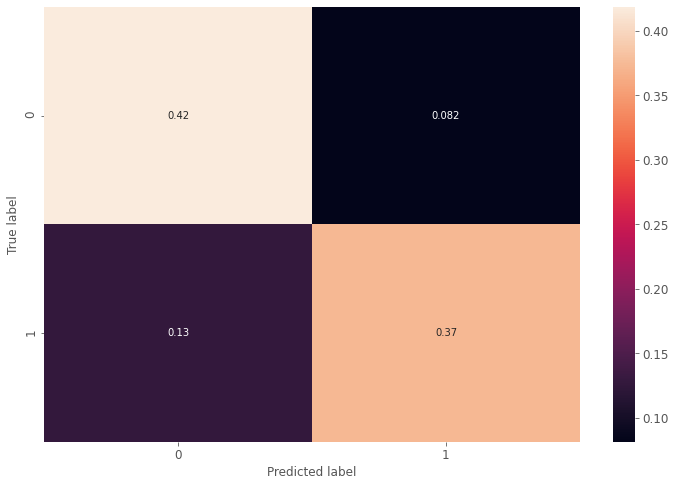

In [203]:
sns.heatmap(confusion_matrix(train[nm_target], model.best_estimator_.predict(train[nm_features]))/len(train),
            annot = True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Final Evaluation

## Taking Just the 'static' testing set.

F1 score, in other words $F_{\beta = 1}$ score.

In [211]:
fbeta_score(y_true = test[nm_target], 
            y_pred = model.best_estimator_.predict(test[nm_features]), 
            beta=1)

0.7730118247159751

$F_{\beta = 0.5}$ score

In [212]:
fbeta_score(y_true = test[nm_target], 
            y_pred = model.best_estimator_.predict(test[nm_features]), 
            beta=0.5)

0.7918487554626638

Accuracy score

In [213]:
accuracy_score(y_true = test[nm_target], 
               y_pred = model.best_estimator_.predict(test[nm_features])
               )

0.7816681534344335

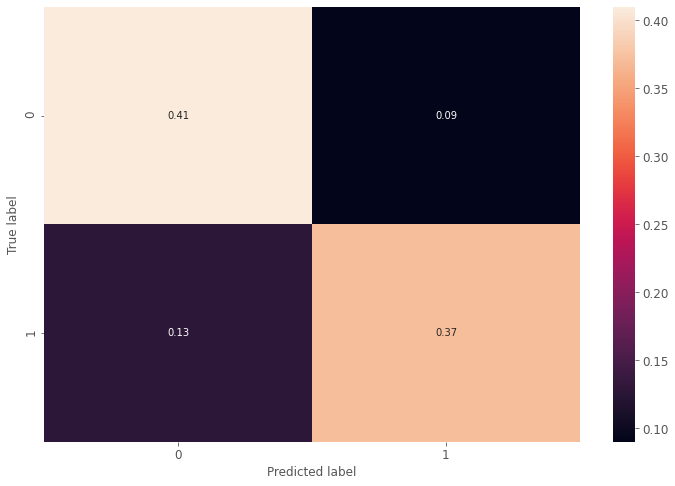

In [303]:
sns.heatmap(confusion_matrix(test[nm_target], model.best_estimator_.predict(test[nm_features]))/len(test),
            annot = True)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Using Multiple Random Samples

> Remember: In the begin of this notebook the strategy to balance data was undersampling using the NearMiss algorithm.

So we have more observations 'set aside' than the test set for majority class. Because NearMiss, in this case, set aside only majority class.

Lets use this observations, following the idea of [Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method).



In [255]:
# Balanced testing set, lets keep this balance.
test[nm_target].value_counts()/len(test)

1    0.5
0    0.5
Name: income, dtype: float64

In [261]:
# zero class observations not used
data.loc[ ~data.index.isin(NearMiss.sample_indices_),nm_target].value_counts()

0    22806
Name: income, dtype: int64

In [266]:
# number of observations by class actually used
data.loc[data.index.isin(NearMiss.sample_indices_),nm_target].value_counts()

1    11208
0    11208
Name: income, dtype: int64

We have more than two times the number of observations left behind by class zero than we actually used!!

In [270]:
(data.loc[ ~data.index.isin(NearMiss.sample_indices_),nm_target].value_counts()/
data.loc[data.index.isin(NearMiss.sample_indices_),nm_target].value_counts()[0])

0    2.034797
Name: income, dtype: float64

In [298]:
f1List = []
fbList = []
acList = []
# Using 100 evaluations
for k in range(100):
  dfone = test.loc[test[nm_target]==1].copy() # ones label testing data
  dfzero = data[~data.index.isin(NearMiss.sample_indices_)].sample(n = len(dfone), random_state = k).copy() # zero labels data
  df = pd.concat([dfone,dfzero]).sample(frac=1, random_state = k) # sample(frac=1) just shuffle the data frame

  # F1 scores
  f1List.append(fbeta_score(y_true = df[nm_target], 
                            y_pred = model.best_estimator_.predict(df[nm_features]), 
                            beta=1)
                )
  
  # F beta=0.5 score
  fbList.append(fbeta_score(y_true = df[nm_target], 
                            y_pred = model.best_estimator_.predict(df[nm_features]), 
                            beta=0.5)
                )
  
  # Accuracy score
  acList.append(accuracy_score(y_true = df[nm_target], 
                               y_pred = model.best_estimator_.predict(df[nm_features])
                               )
                )


$F_{\beta = 1}$ mean score

In [299]:
np.mean(f1List)

0.7993326456786298

$F_{\beta = 0.5}$ mean score

In [300]:
np.mean(fbList)

0.7511477376532188

Accuracy mean score

In [301]:
np.mean(acList)

0.77528545941124

# Conclusion

As seem above, the scores in training set and test set are quite close and greater than 50% (Naive estimation). 

It means that we do not have problems as underfitting or overfitting here.

And also comparing the results with other references like [here](https://towardsdatascience.com/classification-project-finding-donors-853db66fbb8c) and [here](https://github.com/lmego/finding_donors/blob/master/finding_donors.ipynb), this approach have a good enough (maybe a little better) result.  

The results from idea of Monte Carlo Method just reinforce this conclusion.

Best Regards, Tiago and Vitor!